In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception,MobileNetV2,NASNetMobile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np
import os
import seaborn as sns
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import SimpleITK as sitk
import pathlib

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [2]:
df = pd.read_csv('D:/Kaggle datasets/Blood Analysis/ExportAnnotationsForTensorFlow/greenToolAnnotations/Classify_Results.csv')
df.head(10)

,Image ID,Class,Score(%)
0,100605201901 _Cropped_LED1 _Lane[1]_RackIndex_...,Blue,100.0000
1,100605201901 _Cropped_LED2 _Lane[1]_RackIndex_...,White,99.9999
2,100605201902 _Cropped_LED1 _Lane[1]_RackIndex_...,Blue,100.0000
3,100605201902 _Cropped_LED2 _Lane[1]_RackIndex_...,White,99.9999
4,100605201903 _Cropped_LED1 _Lane[1]_RackIndex_...,Blue,99.9999
5,100605201903 _Cropped_LED2 _Lane[1]_RackIndex_...,White,99.9999
6,100605201904 _Cropped_LED1 _Lane[1]_RackIndex_...,Blue,99.9999
7,100605201904 _Cropped_LED2 _Lane[1]_RackIndex_...,White,99.9999
8,100605201905 _Cropped_LED1 _Lane[1]_RackIndex_...,Blue,100.0000
9,100605201905 _Cropped_LED2 _Lane[1]_RackIndex_...,White,99.9998


White    96
Blue     96
Name: Class, dtype: int64


<AxesSubplot:xlabel='Class', ylabel='count'>

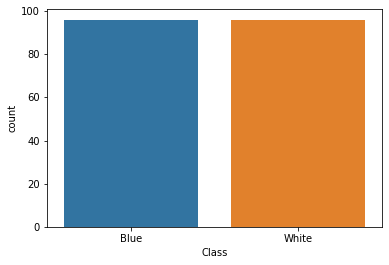

In [3]:
unique_count = df['Class'].value_counts()

print( unique_count)

sns.countplot(x = 'Class', data = df)

In [4]:
df['Class']=df.Class.map({'Blue':0,'White':1})
df.head()

,Image ID,Class,Score(%)
0,100605201901 _Cropped_LED1 _Lane[1]_RackIndex_...,0,100.0000
1,100605201901 _Cropped_LED2 _Lane[1]_RackIndex_...,1,99.9999
2,100605201902 _Cropped_LED1 _Lane[1]_RackIndex_...,0,100.0000
3,100605201902 _Cropped_LED2 _Lane[1]_RackIndex_...,1,99.9999
4,100605201903 _Cropped_LED1 _Lane[1]_RackIndex_...,0,99.9999


In [5]:
path = 'D:/Kaggle datasets/Blood Analysis/imgSelect/'
image_size = 224

X , y = [], []

for i,item in df.iterrows():

    image = sitk.ReadImage(path + item[0] + '.bmp')
    image = sitk.GetArrayFromImage(image)
    image = cv.resize(image,(image_size,image_size))
    X.append(image)
    y.append(item[1])
    
X = np.array(X)
y = np.array(y)
y = np.expand_dims(y,axis=1)

In [6]:
print(X.shape)
print(y.shape)

(192, 224, 224, 3)
(192, 1)


[1]


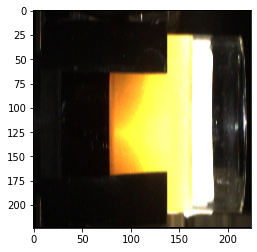

In [7]:
plt.imshow(X[5])
plt.show
print(y[5])

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.2)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(153, 224, 224, 3)
(39, 224, 224, 3)
(153, 1)
(39, 1)


In [9]:
def get_train_generator(X_train,y_train, batch_size =4, shuffle = True, seed = 1):
    
    # normalize images
    image_generator = ImageDataGenerator(
        rotation_range = 15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        fill_mode="nearest",
        cval=0.0,
        preprocessing_function=preprocess_input)
    
    generator = image_generator.flow(
            X_train,
            y=y_train,
            shuffle=shuffle,
            batch_size=batch_size,
            seed=seed
            )
    
    return generator

In [10]:
def get_test_generator(X_train, y_train, X_test,y_test,
                      batch_size=4,shuffle=False, seed=1, sample_size=50):

    # use sample to fit mean and std for test set generator
    
    raw_train_generator = ImageDataGenerator().flow(
        X_train,y_train, 
        batch_size=sample_size, 
        shuffle=shuffle)
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)
    
    # get test generator
    test_generator = image_generator.flow(
            X_test,
            y=y_test,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed)
    
    return test_generator

In [11]:
train_generator = get_train_generator(X_train,y_train)
test_generator = get_test_generator(X_train,y_train,X_test,y_test)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


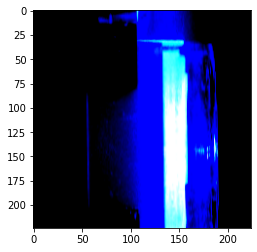

In [12]:
x, y = train_generator.__getitem__(3)
plt.imshow(x[0]);

In [13]:
input_shape=[224,224]

base_model = MobileNetV2 (input_shape = input_shape+[3], weights = 'imagenet', include_top = False)

x = base_model.output

x = GlobalAveragePooling2D()(x)

x = Dense(1024,activation='relu')(x)
x = Dropout(0.2)(x)

# and a logistic layer
out = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=out)

In [14]:
def scheduler(epoch):
    if epoch < 30:
        return 0.0001
    else:
        return 0.0001 * tf.math.exp(0.1 * (10 - epoch))

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [15]:
model.compile(optimizer='adam', loss="binary_crossentropy", metrics=["accuracy"])
model.summary()  

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

In [16]:
callbacks = tf.keras.callbacks.ModelCheckpoint('Mobilenet.h5', monitor='val_loss', verbose=1, save_best_only=True, mode = 'auto')

batch_size = 4

r = model.fit(train_generator, validation_data=(test_generator), 
                        steps_per_epoch = X_train.shape[0]//batch_size, epochs= 50, 
                        callbacks = [callbacks,lr_schedule,stopping])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 38 steps, validate for 10 steps
Epoch 1/50
36/38 [===========================>..] - ETA: 0s - loss: 0.2545 - accuracy: 0.9149
Epoch 00001: val_loss improved from inf to 1.42601, saving model to Mobilenet.h5
38/38 [==============================] - 10s 253ms/step - loss: 0.2416 - accuracy: 0.9195 - val_loss: 1.4260 - val_accuracy: 0.4872
Epoch 2/50
36/38 [===========================>..] - ETA: 0s - loss: 0.1396 - accuracy: 0.9574
Epoch 00002: val_loss did not improve from 1.42601
38/38 [==============================] - 1s 33ms/step - loss: 0.1327 - accuracy: 0.9597 - val_loss: 1.7798 - val_accuracy: 0.4872
Epoch 3/50
36/38 [===========================>..] - ETA: 0s - loss: 0.1062 - accuracy: 0.9574
Epoch 00003: val_loss did not improve from 1.42601
38/38 [==============================] - 1s 34ms/step - loss: 0.1006 - accuracy: 0.9597 - val_loss: 1.9227 - val_accuracy: 0.4872
Epoch 4/50
36/38 [===========================>..] -

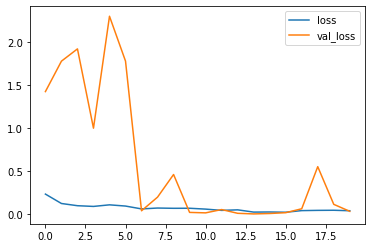

In [17]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

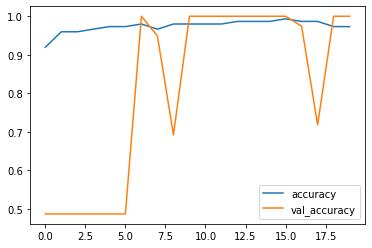

In [18]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [20]:
P= model.predict(test_generator, steps=len(test_generator)).argmax(axis=1)

([<matplotlib.axis.YTick at 0x28c98cbab48>,
 [Text(0, 0, 'Blue'), Text(0, 1, 'White')])

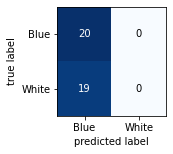

In [21]:
matrix = confusion_matrix (y_test, P)
plot_confusion_matrix(matrix, figsize=(2,2))
plt.xticks(range(2), ['Blue','White'], fontsize=10)
plt.yticks(range(2), ['Blue','White'], fontsize=10)

In [22]:
KERAS_MODEL_NAME = "mobilenet.h5"
model.save(KERAS_MODEL_NAME)

In [24]:
TF_LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"

tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()

In [25]:
tflite_model_name = TF_LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)

14103056

In [26]:
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')

In [28]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

File size: 41.426 Megabytes


In [29]:
interpreter = tf.lite.Interpreter(model_path = TF_LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [1 1]
Output Type: <class 'numpy.float32'>


In [ ]:
interpreter.resize_tensor_input(input_details[0]['index'], (10000, 224, 224))
interpreter.resize_tensor_input(output_details[0]['index'], (10000, 1))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

In [31]:
#Now load the model using the TFLiteConverter

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [34]:
tflite_models_dir = pathlib.Path("/tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [35]:
tflite_model_file = tflite_models_dir/"classify_model.tflite"
tflite_model_file.write_bytes(tflite_model)

14103056

In [36]:
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]

In [37]:
tflite_fp16_model = converter.convert()
tflite_model_fp16_file = tflite_models_dir/"classify_model_quant_f16.tflite"
tflite_model_fp16_file.write_bytes(tflite_fp16_model)

7076572

In [38]:
interpreter = tf.lite.Interpreter(model_path=str(tflite_model_file))
interpreter.allocate_tensors()

In [39]:
interpreter_fp16 = tf.lite.Interpreter(model_path=str(tflite_model_fp16_file))
interpreter_fp16.allocate_tensors()

In [40]:
test_image = np.expand_dims(X_test[0], axis=0).astype(np.float32)

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

interpreter.set_tensor(input_index, test_image)
interpreter.invoke()
predictions = interpreter.get_tensor(output_index)

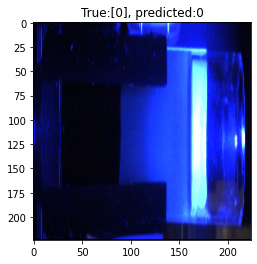

In [42]:
plt.imshow(X_test[0])
template = "True:{true}, predicted:{predict}"
_ = plt.title(template.format(true= str(y_test[0]),
                              predict=str(np.argmax(predictions[0]))))
plt.grid(False)